# Imports

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd

# Init

In [16]:
df = pd.read_csv("preprocessed_hourly_data.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

features = ['Open', 'High', 'Low', 'SMA_200', 'ATR_168']
target_column = 'Close'

df = df.dropna()

# Train-Val-Test Split

In [17]:
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)

train_data = df.iloc[:train_size]
val_data = df.iloc[train_size:train_size + val_size]
test_data = df.iloc[train_size + val_size:]

# Scaling

In [18]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

train_features_scaled = scaler_X.fit_transform(train_data[features])
val_features_scaled = scaler_X.transform(val_data[features])
test_features_scaled = scaler_X.transform(test_data[features])

train_target_scaled = scaler_y.fit_transform(train_data[[target_column]])
val_target_scaled = scaler_y.transform(val_data[[target_column]])
test_target_scaled = scaler_y.transform(test_data[[target_column]])

# Sequence Making

In [19]:
def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = target[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 9

In [20]:
X_train, y_train = create_sequences(train_features_scaled, train_target_scaled, seq_length)
X_val, y_val = create_sequences(val_features_scaled, val_target_scaled, seq_length)
X_test, y_test = create_sequences(test_features_scaled, test_target_scaled, seq_length)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).squeeze()
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).squeeze()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).squeeze()

# Data Loader

In [21]:
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=128)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=128)

# Model

In [22]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                     dilation=dilation_size, padding=(kernel_size-1) * dilation_size,
                                     dropout=dropout)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class DualAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.query_layer = nn.Linear(hidden_size, hidden_size)
        self.key_layer = nn.Linear(hidden_size, hidden_size)
        self.value_layer = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        Q, K, V = self.query_layer(x), self.key_layer(x), self.value_layer(x)
        attention = self.softmax(torch.bmm(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5))
        return torch.bmm(attention, V)

class TCNWithAttention(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=2, dropout=0.2):
        super().__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout)
        self.attention1 = DualAttention(num_channels[-1])
        self.attention2 = DualAttention(num_channels[-1])
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        tcn_out = self.tcn(x).permute(0, 2, 1)
        attn_out = self.attention1(tcn_out)
        attn_out = self.attention2(attn_out)
        return self.linear(attn_out[:, -1, :])

# Training

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCNWithAttention(input_size=len(features), output_size=1,
                         num_channels=[32, 32], dropout=0.2).to(device)

criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

best_val_loss = float('inf')
patience_counter = 0
num_epochs = 100
early_stop_patience = 10

In [24]:
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        loss = criterion(model(X_batch).squeeze(), y_batch.squeeze())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            loss = criterion(model(X_batch).squeeze(), y_batch.squeeze())
            val_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

Epoch 1: Train Loss = 0.0067, Val Loss = 0.0228
Epoch 2: Train Loss = 0.0005, Val Loss = 0.0018
Epoch 3: Train Loss = 0.0003, Val Loss = 0.0028
Epoch 4: Train Loss = 0.0003, Val Loss = 0.0016
Epoch 5: Train Loss = 0.0002, Val Loss = 0.0018
Epoch 6: Train Loss = 0.0002, Val Loss = 0.0015
Epoch 7: Train Loss = 0.0002, Val Loss = 0.0010
Epoch 8: Train Loss = 0.0002, Val Loss = 0.0010
Epoch 9: Train Loss = 0.0002, Val Loss = 0.0010
Epoch 10: Train Loss = 0.0002, Val Loss = 0.0012
Epoch 11: Train Loss = 0.0002, Val Loss = 0.0009
Epoch 12: Train Loss = 0.0002, Val Loss = 0.0010
Epoch 13: Train Loss = 0.0002, Val Loss = 0.0020
Epoch 14: Train Loss = 0.0002, Val Loss = 0.0037
Epoch 15: Train Loss = 0.0002, Val Loss = 0.0013
Epoch 16: Train Loss = 0.0002, Val Loss = 0.0053
Epoch 17: Train Loss = 0.0001, Val Loss = 0.0010
Epoch 18: Train Loss = 0.0001, Val Loss = 0.0016
Epoch 19: Train Loss = 0.0001, Val Loss = 0.0009
Epoch 20: Train Loss = 0.0001, Val Loss = 0.0008
Epoch 21: Train Loss = 0.0001

# Evaluation

In [25]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    predictions = model(X_test_tensor).squeeze().cpu().numpy()
    actuals = y_test_tensor.squeeze().numpy()

# DeScaling

In [26]:
predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()

# Evaluation

In [27]:
mse = np.mean((predictions - actuals) ** 2)
naive_preds = actuals[:-1]
naive_actuals = actuals[1:]
naive_mse = np.mean((naive_preds - naive_actuals) ** 2)

huber_loss_fn = nn.HuberLoss()
predictions_tensor = torch.tensor(predictions, dtype=torch.float32)
actuals_tensor = torch.tensor(actuals, dtype=torch.float32)
huber_loss = huber_loss_fn(predictions_tensor, actuals_tensor).item()

print(f"TCN Model MSE: {mse:.4f}")
print(f"Naive Baseline MSE: {naive_mse:.4f}")
print(f"Huber Loss on Test Set: {huber_loss:.4f}")

TCN Model MSE: 208788.2188
Naive Baseline MSE: 125039.3438
Huber Loss on Test Set: 276.8379


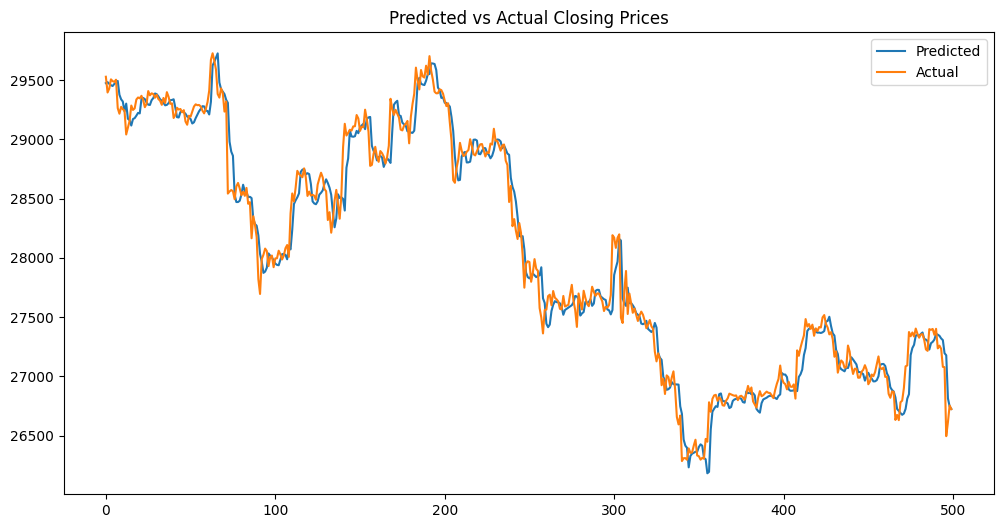

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(predictions[:500], label='Predicted')
plt.plot(actuals[:500], label='Actual')
plt.title('Predicted vs Actual Closing Prices')
plt.legend()
plt.show()